# Loan Approval Prediction
Edmund Walsh - May 10th, 2020

## Introduction
The project examines the data provided by the Home Mortgage Disclosure Act (HMDA) which requires mortgage lenders in the United States to disclose information about the mortgage lending decisions they have made. Specifically, we will be examining prediction of whether or not an application will be accepted or denied.

This notebook is part of a short 5-day project whose purpose goes beyond the acceptance prediction of mortgages. The focus of this project is more about the process and end-to-end engineering from raw data to results and presentation. This notebook will focus on the data science approach and process and highlight a roadmap best illustrated in the image below:

<img src='https://miro.medium.com/max/1400/1*LoBdYL_YyIcYJ842peLDpQ.jpeg'
     alt='Data Science & Data Engineering'
     style='height: 350px; width: 750px;' />

## A Ground Up Approach
The pyramid above is such a good illustration because the process truly is building in a step-by-step fashion 
towards the ultimate goal of finding useful results that are actionable and impactful in the real world. 
The end results get all of the attention, but a project is unlikely to be successful without these strong foundations.

## Context 
While this project request didn't specifically state 'why' we are looking into this data, I will work within the context of three important rationales.
1. Mortgage due diligence is expensive and time intensive. A process that can more reliably expidite the process will save lenders significant time and resources.
2. From a regulatory perspective and also importantly as Machine Intelligence becomse a larger and more common part of this process it is important for us to be aware of and highlight any bias.
3. Some financial instituions may be more or less likely to issue mortgages and this may reflect either an over or under utilization of the balance sheet or their risk appetite.

### Preparation
Before digging in, let's install our python requirements and follow the instructions for setting up our docker environment and tools in the [README.md](file:///../README.md)

In [1]:
pip install --user -r ./misc/requirements.txt

  Using cached https://files.pythonhosted.org/packages/3f/4e/b9a5cb7c7451029f67f93426cbb5f5bebedc3f9a8b0a470de7d0d7883602/psycopg2_binary-2.7.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e6/de/a0d3defd8f338eaf53ef716e40ef6d6c277c35d50e09b586e170169cdf0d/pandas-0.24.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/23/7e/93c325482c328619870b6cd09370f6dbe1148283daca65115cd63642e60f/psycopg2-2.8.2.tar.gz
    100% |████████████████████████████████| 276kB 2.9MB/s ta 0:00:01
    100% |████████████████████████████████| 20.4MB 64kB/s  eta 0:00:01
    100% |████████████████████████████████| 143kB 5.4MB/s eta 0:00:01
    100% |████████████████████████████████| 12.4MB 104kB/s eta 0:00:01
    100% |████████████████████████████████| 225kB 3.8MB/s eta 0:00:01
    100% |████████████████████████████████| 512kB 2.1MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 4.2MB/s eta 0:00:01
    100% |█████████

### Package Import
Now we can begin importing the required packages. Many of these are common python packages, the exception is seed which is a set of functions we will use to import our initial data and begin our collect step on our roadmap.

In [2]:
import seed
import pandas as pd
import numpy as np
import os
import config
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

### A Discussion of the data
Our data sources will come from three major sources and we will use their APIs to download the data.
1. Our main dataset comes from the HMDA database and includes not only a large set of information about the individual loan approval decision but also information about the originating institutions.
    a. A full list of available data on the mortgage approvals can be found [here](http://cfpb.github.io/api/hmda/fields.html)
    b. We also will look at the originating instituions and information about that dataset can be found [here](https://api.consumerfinance.gov/data/hmda/slice/institutions/metadata)
2. Our next and complementary set of information comes from the census bureau. We will use their county business patterns series which aggregate economic information at a county level. I hope that this information will provide some valueable economic insight into regional economics that may affect an mortgage approval decision.
    a. Details about this dataset can be found [here](https://www.census.gov/programs-surveys/cbp.html)
    b. This API requires a key which you can sign up for [here](https://api.census.gov/data/key_signup.html)
    c. After you have signed up, please include this key in the [config.py](file:///./config.py) file.
3. Finally, we will also fill in some data from Federal Reserve Bank of St. Louis. This data will come into use towards the end of the project as we begin to look across time periods as it should give us an indication of both the financial conditions and sentiment of the originating institutions.
    a. Details about this API can be found [here](https://fred.stlouisfed.org/docs/api/fred/)

In [3]:
# after configuring the census API re-import config and check api key
import config
print(config.api_key)

8dadaedad2b940dd8ffff397507286b479540d00


### Data Collection
Luckily for us, the designers of the APIs have made this pretty easy. A big thank you to them!

To start, I have selected a single year and a single state. Feel free to change to your preferences, data is available from 2007 - 2017. Some important caveats. As this is an illustrative project only, there are some important details about availability of data (i.e. when it was published) and data type issues that would require more attention in a production environment.

In [4]:
# choose a first state by two letter code and year
init_state = "OH"
init_yr = 2016

In [6]:
# pull data from the HMDA database on mortgage approvals -- this may take awhile
data_lar = seed.lar_pull(init_state, init_yr)

In [7]:
# a quick data snapshot
data_lar.head() 

,action_taken,action_taken_name,agency_code,agency_abbr,agency_name,applicant_ethnicity,applicant_ethnicity_name,applicant_income_000s,applicant_race_1,applicant_race_2,...,state_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,rate_spread,tract_to_msamd_income,uuid
0,1,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,75,5,NaN,...,Ohio,66600,219,3165,2746,9.869999885559082,10439,NaN,148.33999633789062,8019b959-b43a-44f0-b66e-6630d96e8299
1,3,Application denied by financial institution,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,60,5,NaN,...,Ohio,69100,293,3131,2921,16.459999084472656,8742,NaN,172.69000244140625,e59165e0-155f-40b8-9662-ec80a940fa8e
2,1,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,87,5,NaN,...,Ohio,66600,104,2320,1485,4.429999828338623,5508,NaN,89.05000305175781,4f4eabd7-4e69-431c-92f9-7819188182aa
3,1,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,86,5,NaN,...,Ohio,55400,153,948,809,2.490000009536743,2973,NaN,133.8300018310547,16d04a81-ac51-42af-b464-5ddc27f438a2
4,1,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,46,5,NaN,...,Ohio,66600,206,2375,2210,5.340000152587891,6044,NaN,126.06999969482422,10da48f8-f6d6-45d1-88ed-635d7dc2f47f


In [8]:
'{:,.0f}'.format(data_lar.shape[0]) + ' total rows  for a total of ' + \
'{:,.0f}'.format(data_lar.shape[0]*data_lar.shape[1]) + ' data points'

'493,271 total rows  for a total of 38,968,409 data points'

In [9]:
# Now pull county business patters data from the census bureau
census_df = seed.census_pull(init_state, init_yr, data_lar, config.api_key)

In [9]:
# A quick snapshot
census_df.head()

,EMP,ESTAB,PAYANN,POP,county_code,county_name,state_abbr,state_code,year
0,3899081,195687,210202807,1250871,35,"Cuyahoga County, Ohio",OH,39,2016
1,3775265,169990,190400631,1138190,49,"Franklin County, Ohio",OH,39,2016
2,466581,35316,20664563,227255,85,"Lake County, Ohio",OH,39,2016
3,201710,14425,7926456,111289,169,"Wayne County, Ohio",OH,39,2016
4,2809075,125607,159909829,782863,61,"Hamilton County, Ohio",OH,39,2016


In [10]:
'{:,.0f}'.format(census_df.shape[0]) + ' total rows  for a total of ' + \
'{:,.0f}'.format(census_df.shape[0]*census_df.shape[1]) + ' data points'

'88 total rows  for a total of 792 data points'

In [11]:
# Finally, let's pull data about the originating institutions
data_inst = seed.inst_pull(init_state, init_yr)

In [12]:
# A quick snapshot
data_inst.head()

,activity_year,respondent_id,agency_code,agency_abbr,agency_name,federal_tax_id,respondent_name,respondent_address,respondent_city,respondent_state,...,parent_state,parent_zip_code,respondent_name_panel,respondent_city_panel,respondent_state_panel,other_lender_code,region_code,validity_error,assets,lar_count
0,2016,0000000046,1,OCC,Office of the Comptroller of the Currency,31-4247738,FIRST NATIONAL BANK OF MCCONNE,"86 N. KENNEBEC AVENUE, PO BOX 208",MCCONNELSVILLE,OH,...,OH,43756,FIRST NB,MCCONNELSVILLE,OH,0,3,N,138285,129
1,2016,0000000047,1,OCC,Office of the Comptroller of the Currency,35-0704860,FIRST FINANCIAL BANK NA,1401 S 3RD ST,TERRE HAUTE,IN,...,IN,47807,FIRST FNCL BK NA,TERRE HAUTE,IN,0,3,N,2882577,2695
2,2016,0000000086,1,OCC,Office of the Comptroller of the Currency,31-0294798,FIRST NATIONAL BANK OF GERMANT,17 NORTH MAIN STREET,GERMANTOWN,OH,...,NaN,NaN,FIRST NB,GERMANTOWN,OH,0,3,N,52364,38
3,2016,0000000324,1,OCC,Office of the Comptroller of the Currency,23-0916895,FIRST NATIONAL BANK AND TRUST,40 SOUTH STATE ST,NEWTOWN,PA,...,NaN,NaN,FIRST NB&TC NEWTOWN,NEWTOWN,PA,0,1,N,860869,184
4,2016,0000000325,1,OCC,Office of the Comptroller of the Currency,24-0558097,"FNB BANK, NA",354 MILL STREET,DANVILLE,PA,...,PA,17604,FNB BK NA,DANVILLE,PA,0,1,N,363285,270


In [13]:
'{:,.0f}'.format(data_inst.shape[0]) + ' total rows  for a total of ' + \
'{:,.0f}'.format(data_inst.shape[0]*data_inst.shape[1]) + ' data points'

'100 total rows  for a total of 2,400 data points'

### Data Storage
We are very early on, but we have already pulled together a rather large dataset. So, after building on our foundataion of data collection, where we know have functions that can pull and update the necessary data, we need to start thinking about data storage and the tools we are going to need to scale up analysis.

For data storage this project will rely on PostgreSQL. This is a powerful, open source object-relational database which is well suited for the type of data we are working with.

For processing and analysis we will rely on Spark, which has a deep library for classification and analytics but also is very scalable as more resources can be added to a cluster very easily.

Thinking about how we can go to one small slice of data to the entire dataset over all available years ahead of time will save us a lot of headache going forward. To help us in this endeavor I will be using Docker Compose to run these services. This setup will be helpful when we scale up operations as we will see.

If you have not already, please follow the instructions in the [README.md](file:///../README.md).

In [15]:
# after the setup we are ready to load the data we have downloaded into our database
import load
load.load()

Loading started
Establising connection to database hmda_db listening on 0.0.0.0, port 54320 with user name: postgres.
Connection success.
Created lar table.
Created fips table.
Created institutions table.
Created fred table.
Created census table.
Committed all creations.
Started to load lar data to db from /home/edmund/Projects/hmda/data/load/hmda_lar.csv.
Completed loading lar table.
Started to load fips data to db from /home/edmund/Projects/hmda/data/load/hmda_fips.csv.
Completed loading fips table.
Started to load institutions data to db from /home/edmund/Projects/hmda/data/load/hmda_institutions.csv.
Completed loading institutions table.
Started to load fred data to db from /home/edmund/Projects/hmda/data/load/hmda_fred.csv.
Completed loading fred table.
Started to load census data to db from /home/edmund/Projects/hmda/data/load/hmda_census.csv.
Completed loading census table.
Loading completed.


### Exploratory Data Analysis, Transformation, & Feature Engineering
Now that we have our data loaded, we can begin to do some initial analysis. As we step through the available data we should take care to think about how it can be interpreted and to make sure we set ourselves up for success by looking at abnormal features like outliers or highly skewed distributions.

We have done our job in getting the data together and stored. But now we need to make sure we have informative features. In my humble opinion, this is where a lot of value can be added or a things can go wrong so we will spend a fair amount of time in this section. Before we can even truly to any exploratory analysis we will need to preprocess a lot of this data so we can make better sense of it.

First and most importantly, if we take a look at the variable we will be trying to predict/classify we can it can take a few different forms.

In [49]:
df = pd.DataFrame(set(data_lar['action_taken_name'])).rename(columns={0:'action_taken_name'})
df.style.set_properties(**{'width':'100%', 'text-align':'center'})

,action_taken_name
0,Preapproval request denied by financial institution
1,Application withdrawn by applicant
2,Application approved but not accepted
3,Loan originated
4,File closed for incompleteness
5,Application denied by financial institution
6,Loan purchased by the institution


We need to define what meets our criteria. For this project we are interested in approvals. So if the loan is originated that is an approval, but so is if the application was approved by it was withdrawn by the applicant. On the other hand, we will define application denied by the financial instituion as unapproved but also if the preapproval request was denied by the instituion.

This leave several actions that we will filter out of our dataset. These will be:
1. When loans are puchased by other institutions
2. For incompleteness
3. When the applicant withdraws the application

In [108]:
data_lar['action_taken'] = pd.to_numeric(data_lar['action_taken'])
lar = data_lar[(data_lar['action_taken'] != 6)]
lar = lar[(lar['action_taken'] != 5)]
lar = lar[(lar['action_taken'] != 4)]
"""dropped {} observations""".format(data_lar.shape[0] - lar.shape[0])

'dropped 127975 observations'

Another important filter we should impose is when income is missing from the dataset. Income is likely to be one of the most important features here, so if that isn't included in the data we shouldn't include it for now.

In [109]:
start_obs = lar.shape[0]
lar = lar[(lar['applicant_income_000s'].apply(lambda x: math.isnan(float(x))) == False)]
"""dropped {} observations""".format(start_obs - lar.shape[0])

'dropped 25203 observations'

Still, we need to transform our data from text to our binary classification. 1 for approved and 0 for not approved.

It will be important to note how balanced/unbalanced our data is, since a highly unbalanced set will mean an model who selects the more likely outcome will appear to be more correct than it really may be.

In [114]:
approved = np.zeros(lar.shape[0])
ids = (lar['action_taken'] == 1) | (lar['action_taken'] == 2)
approved[ids] = 1
lar['action_taken'] = approved

In [115]:
lar.head()

,action_taken,action_taken_name,agency_code,agency_abbr,agency_name,applicant_ethnicity,applicant_ethnicity_name,applicant_income_000s,applicant_race_1,applicant_race_2,...,state_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,rate_spread,tract_to_msamd_income,uuid
0,1.0,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,75,5,NaN,...,Ohio,66600,219,3165,2746,9.869999885559082,10439,NaN,148.33999633789062,aca97d99-a02f-4864-ba99-fb113ee97591
1,0.0,Application denied by financial institution,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,60,5,NaN,...,Ohio,69100,293,3131,2921,16.459999084472656,8742,NaN,172.69000244140625,7274fd7f-588e-4866-a980-9e281edccf0a
2,1.0,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,87,5,NaN,...,Ohio,66600,104,2320,1485,4.429999828338623,5508,NaN,89.05000305175781,20f553dc-ab27-4878-a7c5-3d709ccfa92f
3,1.0,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,86,5,NaN,...,Ohio,55400,153,948,809,2.490000009536743,2973,NaN,133.8300018310547,99735da5-d264-4bb5-af0b-1450fc7bcf88
4,1.0,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,46,5,NaN,...,Ohio,66600,206,2375,2210,5.340000152587891,6044,NaN,126.06999969482422,52edca07-a1c4-48de-a440-54d5546e58b7


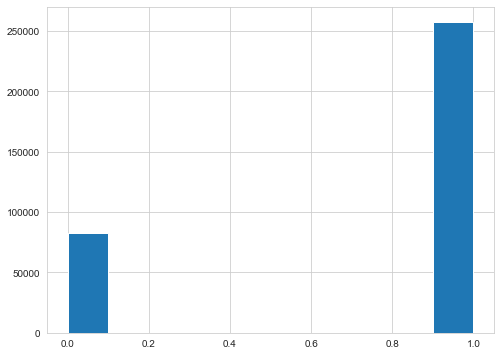

In [120]:
plt.figure(figsize=(8,6))
plt.hist(lar['action_taken']);

While our dataset is unbalanced, it is not extremely so.

I have already mentioned that I expect income to be an important feature of our data. However, it comes in a few different forms. Let's examine our income data and look at how we might transform them below.

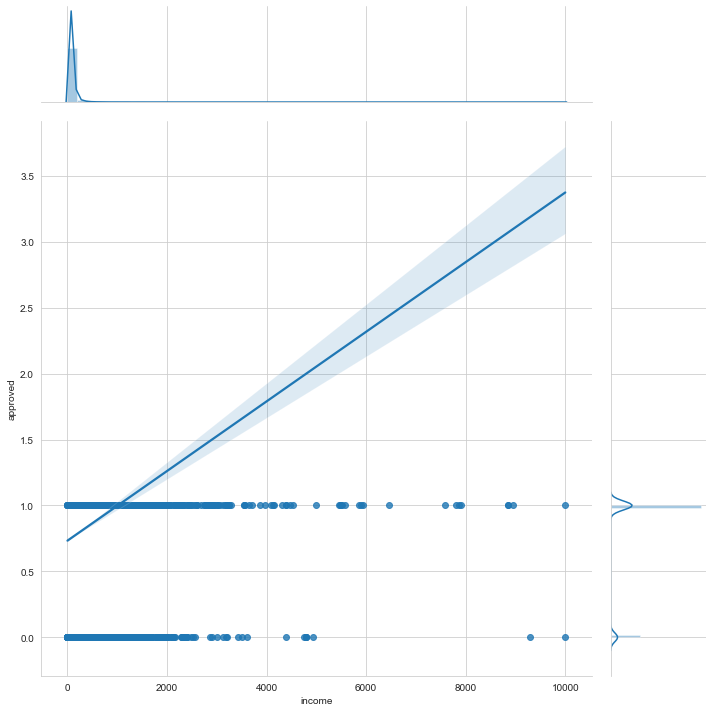

In [133]:
income_data = pd.DataFrame({'approved': lar['action_taken'], \
                            'income': pd.to_numeric(lar['applicant_income_000s'])})
sns.jointplot(y='approved',x='income', data=income_data, kind='reg', height=10)